In [192]:
import pandas as pd
import geopandas as gpd
import numpy as np
import urllib
import glob
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import shapely
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from geopandas.tools import sjoin
from fiona.crs import from_epsg
from math import sin, cos, sqrt, atan2
import mapclassify as mc
import math
import libpysal as lps
import math
import scipy.fftpack
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
url = 'https://raw.githubusercontent.com/lavsz/dsc-mod-2-project-v2-1-onl01-dtsc-pt-052620/master/kc_house_data.csv'

In [3]:
df = pd.read_csv(url)

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

# <span style="color:##FF1493"> 1. Clean and formatting </span>
Waterfront, Basement, Renovating year Values, Date

## 1.1 Waterfront

In [6]:
df.waterfront.unique()

array([nan,  0.,  1.])

In [7]:
# Water front
# Based on King's County's map
# we assume that if any houses with nan value fall within the follow zips
# Are going to assign a 1, otherwise 0 
water_zip = [98177, 98117, 98199, 98119, 98121, 
             98101, 98104, 98134, 98126, 98116, 
             98136, 98136, 98166, 98196, 98070]
df['waterfront_adj'] = df['waterfront']
for i in range(len(df)):
    if np.isnan(df['waterfront_adj'][i]) == 1:
        if df.zipcode[i] in water_zip:
            df['waterfront_adj'][i] = 1
        elif df.zipcode[i] not in water_zip:
            df['waterfront_adj'][i] = 0
        else:
            df['waterfront_adj'][i] = df.waterfront[i]

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


## 1.2 Basement Square Footage

In [8]:
# Basement sqft is object is very odd
df.sqft_basement.unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

In [9]:
# replace the '?' with 0.0 first
# change the dtype to float
df.sqft_basement = df.sqft_basement.str.replace('?', '0.0')
df.sqft_basement = df.sqft_basement.astype(float)

## 1.3 Renovating years

In [10]:
# renovating years
df.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [11]:
# replace nan with just 0 
df.yr_renovated = df.yr_renovated.fillna(0)
df.yr_renovated.unique()

array([   0., 1991., 2002., 2010., 1992., 2013., 1994., 1978., 2005.,
       2003., 1984., 1954., 2014., 2011., 1983., 1945., 1990., 1988.,
       1977., 1981., 1995., 2000., 1999., 1998., 1970., 1989., 2004.,
       1986., 2007., 1987., 2006., 1985., 2001., 1980., 1971., 1979.,
       1997., 1950., 1969., 1948., 2009., 2015., 1974., 2008., 1968.,
       2012., 1963., 1951., 1962., 1953., 1993., 1996., 1955., 1982.,
       1956., 1940., 1976., 1946., 1975., 1964., 1973., 1957., 1959.,
       1960., 1967., 1965., 1934., 1972., 1944., 1958.])

## 1.4 Sales date

In [12]:
# Sales data to datetime format
# Easy to extract month, year, weekdays for further analysis
df.date = pd.to_datetime(df.date, format='%m/%d/%Y')

## 1.5 Views

In [13]:
df.view = df.view.fillna(0)

# <span style="color:##FF1493"> 3. Finding outliers </span>

In [14]:
with pd.option_context('display.max_columns', 40):
    print(df.describe())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159700e+04  21597.000000  19221.000000  21597.000000  21597.000000   
mean   1.509941e+04      1.494096      0.007596      0.233181      3.409825   
std    4.141264e+04      0.539683      0.086825    

In [15]:
# 33 bedrooms seems very odd and need to check out the size of the house
bed_33 = df[df.bedrooms == 33]
bed_33

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,waterfront_adj
15856,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0.0,0.0,...,1040,580.0,1947,0.0,98103,47.6878,-122.331,1330,4700,0.0


In [16]:
# Based on the number of bathrooms, living sqft, it is definitely a typo
# The value will be corrected to 3 instead
df.bedrooms = df.bedrooms.replace({33: 3})

In [17]:
df['FAR'] = (df.sqft_living/df.floors)/df.sqft_lot
df['bd_ba_ratio'] = df.bedrooms/df.bathrooms
df['age'] = df.date.dt.year - df.yr_built
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'waterfront_adj', 'FAR',
       'bd_ba_ratio', 'age'],
      dtype='object')

## Colinearity

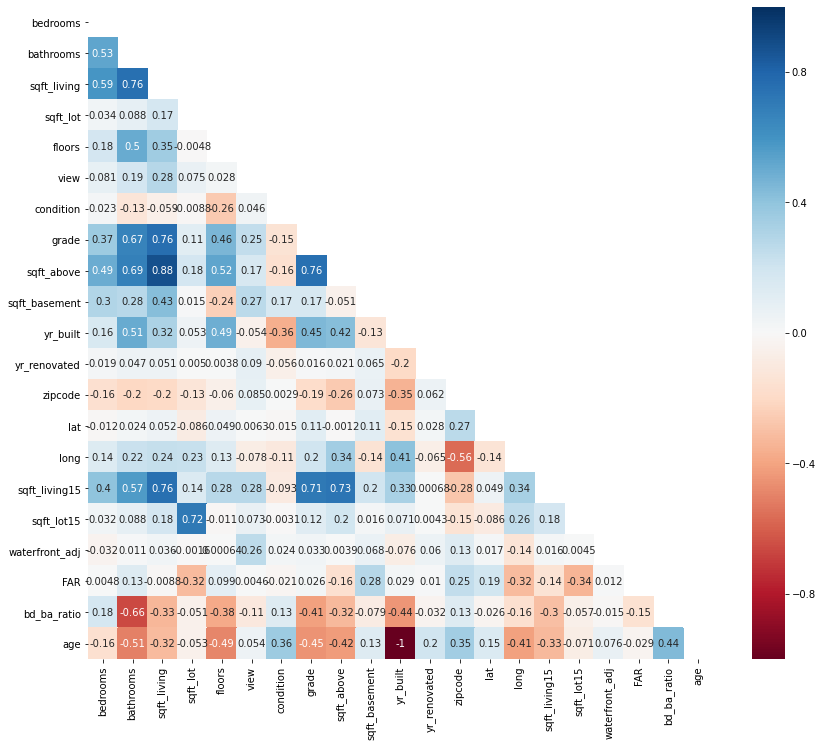

In [18]:
plt.figure(figsize=(14,12))
df_var = df.drop(['price', 'id', 'waterfront'], axis=1)
corr = df_var.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, mask=mask,
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap='RdBu', annot = True)
# 0.7 is a threshold; 

## Interpretations: 
**sqft_living15 & sqft_above** - seems to have strong correlation with many features
<br/>
**sqft_lot15** - not likely going to use it
<br/>
**yr_built** - derived age; and will be dropped
<br/>
**yr_renoved** - many 0 values; it could be that most houses were not renoted or can also be value was acquired; will be dropped
<br/>
**bathroom & bedroom ** - have strong correlation with some features - can be turn into a categorical feature
<br/>
**bd_ba_ratio** - is probably not a good representation as 6 vs 4 and 3 vs 2 have the same ratio but different numbers

In [19]:
df['bed_bath'] = df['bedrooms'].astype(str) + ' - ' + df['bathrooms'].astype(str)

In [20]:
df_clean = df.drop(['waterfront', 'sqft_living15', 'sqft_above', 'sqft_lot15',
                    'yr_built', 'yr_renovated', 'bathrooms', 'bedrooms'], axis=1)

In [21]:
# Creating a new columns - floor area ratio
df_clean['FAR'] = df_clean.sqft_living/df_clean.sqft_lot

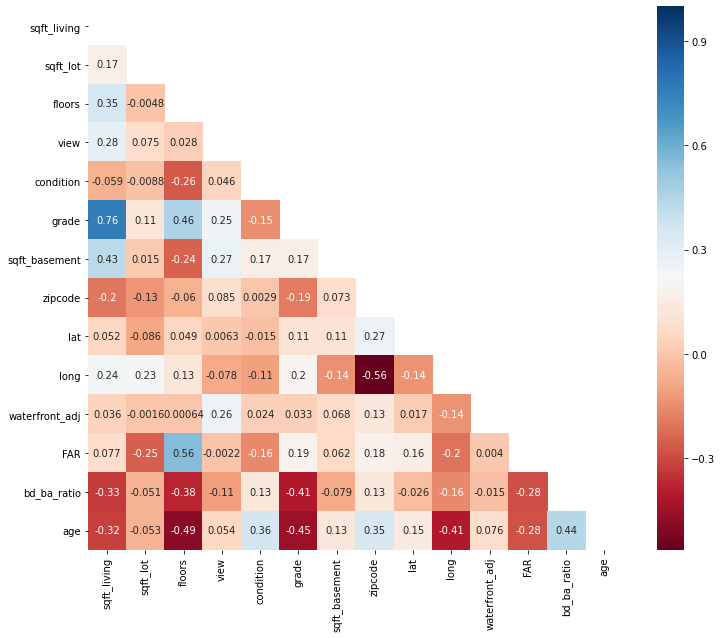

In [22]:
plt.figure(figsize=(12,10))
df_clean_v = df_clean.drop(['price', 'id'], axis=1)
corr_v = df_clean_v.corr()
mask = np.triu(np.ones_like(corr_v, dtype=np.bool))
sns.heatmap(corr_v, mask=mask,
        xticklabels=corr_v.columns,
        yticklabels=corr_v.columns, cmap='RdBu', annot = True)

## Interpretation: 
**Age** might be not easy to interpret when it comes to dealing with price but condition can possibly speak more.
<br/>
**Grade** has a very correlation with sqft_living; it will be turned to categorical data

In [23]:
# getting month & seanson features from data
df_clean['month'] = df_clean.date.dt.month
df_clean['season'] = ' '
df_clean.loc[df_clean.month.isin([3,4,5]), 'season'] = 'Spring'
df_clean.loc[df_clean.month.isin([6,7,8]), 'season'] = 'Summer'
df_clean.loc[df_clean.month.isin([9,10,11]), 'season'] = 'Fall'
df_clean.loc[df_clean.month.isin([12,1,2]), 'season'] = 'Winter'

In [24]:
# change a few features to integer to avoid naming issues
df_clean.view = df_clean.view.astype(int)
df_clean.waterfront_adj = df_clean.waterfront_adj.astype(int)
df_clean.condition = df_clean.condition.astype(int)

# Q2: Marketing and time-series (multivariate, conditional linear reg) can include but not limited to:
Seasonal trend of sales amount, price, house features
<br/>
Seasonal trend of neighbourhood features (perhaps people like to look at waterfront houses in Summer)
<br/>
Categorize features from neighbourhood and generalize overall price for neighbourhoods (spatial lag correction can imply)
<br/>

In [25]:
# Seasonal dataset
df_marking = df_clean[['id', 'date', 'price', 'sqft_living',
       'sqft_lot', 'view', 'condition', 'grade',
       'lat', 'long', 'waterfront_adj',
       'season', 'FAR', 'bed_bath']]

In [26]:
# Demographic and District for map visualization
demographic = 'https://opendata.arcgis.com/datasets/e23a07e847a7440dabac76ede52b521d_2687.zip'
urllib.request.urlretrieve(demographic, 'demo_file.gz')
!mkdir demographic
!unzip -d demographic demo_file.gz
demos = gpd.GeoDataFrame.from_file(glob.glob("demographic/*.shp")[0])

mkdir: demographic: File exists
Archive:  demo_file.gz
replace demographic/Consolidated_Demographics_Index_for_King_County_Census_Tracts___demographic_index_area.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [27]:
# Turning into categorical data
df_marking.grade = df_marking.grade.astype('category')
df_marking['bed_bath'] = df_marking['bed_bath'].astype('category')
df_marking.waterfront_adj = df_marking.waterfront_adj.astype('category')
df_marking.view = df_marking.view.astype('category')
df_marking.condition = df_marking.condition.astype('category')

# Making dummies
grade = pd.get_dummies(df_marking.grade, prefix='grade')   
bed_bath = pd.get_dummies(df_marking['bed_bath'], prefix='bb_ratio')
wat = pd.get_dummies(df_marking.waterfront_adj, prefix='waterfront')
view = pd.get_dummies(df_marking.view, prefix='view')
condition = pd.get_dummies(df_marking.condition, prefix='condition')

/Users/lavendershenghaozhang/.local/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
df_marking_a = df_marking.join([grade, condition, wat, view])
df_marking_analysis = df_marking_a.drop(['grade', 'view', 'bed_bath',
                                         'waterfront_adj', 'condition'], axis=1)
df_marking_analysis.columns

Index(['id', 'date', 'price', 'sqft_living', 'sqft_lot', 'lat', 'long',
       'season', 'FAR', 'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'grade_10', 'grade_11', 'grade_12', 'grade_13',
       'condition_1', 'condition_2', 'condition_3', 'condition_4',
       'condition_5', 'waterfront_0', 'waterfront_1', 'view_0', 'view_1',
       'view_2', 'view_3', 'view_4'],
      dtype='object')

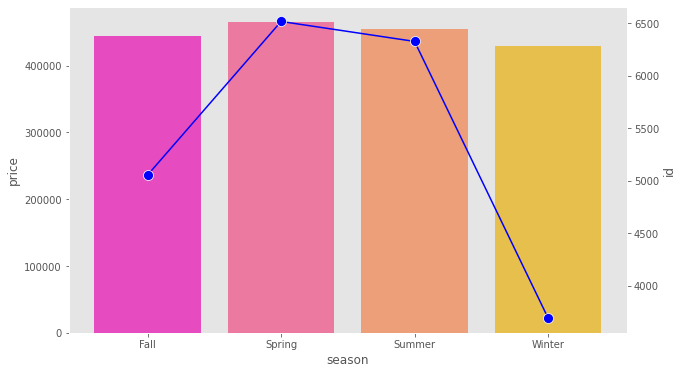

In [29]:
# Visualizing basic info of each season
plt.style.use('ggplot')

fig, ax1 = plt.subplots(figsize=(10,6))
ax1 = sns.barplot(x = df_marking['price'].groupby(df_marking.season).median().index, 
                  y = df_marking['price'].groupby(df_marking.season).median(), palette='spring')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x = df_marking['id'].groupby(df_marking.season).count().index, 
                   y = df_marking['id'].groupby(df_marking.season).count(),
                color='blue', marker='o', markersize=10)
ax2.grid(False)
ax1.grid(False)

In [30]:
# Slicing the data into four subsets representing each season
df_fall = df_marking_analysis[df_marking_analysis.season == 'Fall']
df_winter = df_marking_analysis[df_marking_analysis.season == 'Winter']
df_spring = df_marking_analysis[df_marking_analysis.season == 'Spring']
df_summer = df_marking_analysis[df_marking_analysis.season == 'Summer']

# Creating geo dataframe for each season
geo_fall = gpd.GeoDataFrame(df_fall, geometry=gpd.points_from_xy(df_fall.long, df_fall.lat))
geo_winter = gpd.GeoDataFrame(df_winter, geometry=gpd.points_from_xy(df_winter.long,
                                    df_winter.lat))
geo_spring = gpd.GeoDataFrame(df_spring, geometry=gpd.points_from_xy(df_spring.long,
                                    df_spring.lat))
geo_summer = gpd.GeoDataFrame(df_summer, geometry=gpd.points_from_xy(df_summer.long,
                                    df_summer.lat))

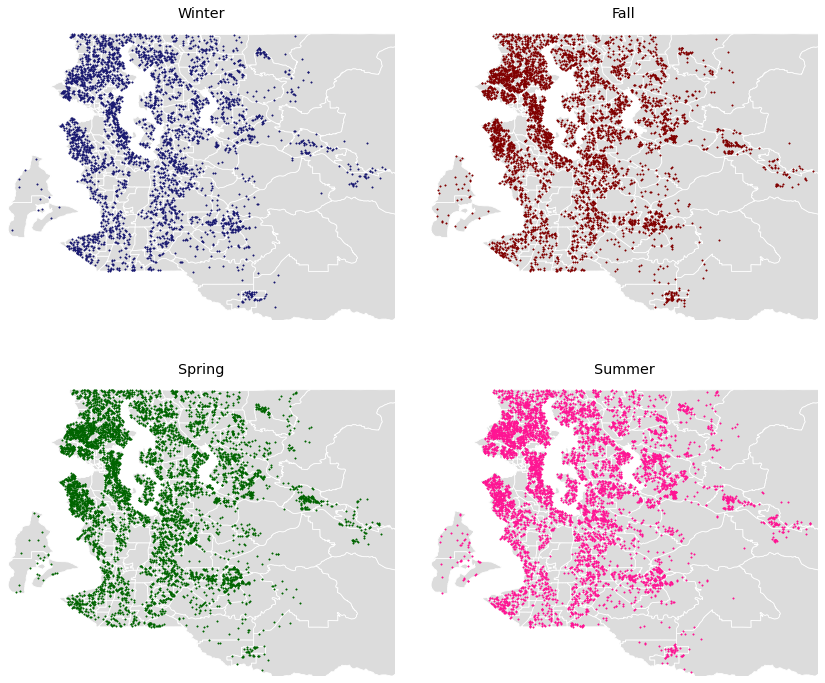

In [31]:
# Geospatil distribution
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(221)
set1 = demos.plot(color='#DCDCDC', ax=ax1, edgecolor='white', linewidth=0.8, legend=True)
set2 = geo_winter.plot(color='#191970', ax=ax1, markersize=2)
set1.set_xlim(-122.53, -121.68)
set1.set_ylim(47.15, 47.8)
set1.axis('off')
set1.set_title('Winter')

ax2 = fig.add_subplot(222)
set3 = demos.plot(color='#DCDCDC', ax=ax2, edgecolor='white', linewidth=0.8,  legend=True)
set4 = geo_fall.plot(color='#800000', ax=ax2, markersize=2)
set3.set_xlim(-122.53, -121.68)
set3.set_ylim(47.15, 47.8)
set3.axis('off')
set3.set_title('Fall')

ax3 = fig.add_subplot(223)
set5 = demos.plot(color='#DCDCDC', ax=ax3, edgecolor='white',linewidth=0.8,  legend=True)
set6 = geo_spring.plot(color='#006400', ax=ax3, markersize=2)
set5.set_xlim(-122.53, -121.68)
set5.set_ylim(47.15, 47.8)
set5.axis('off')
set5.set_title('Spring')

ax4 = fig.add_subplot(224)
set7 = demos.plot(color='#DCDCDC', ax=ax4, edgecolor='white', linewidth=0.8, legend=True)
set8 = geo_summer.plot(color='#FF1493', ax=ax4, markersize=2)
set7.set_xlim(-122.53, -121.68)
set8.set_ylim(47.15, 47.8)
set7.axis('off')
set7.set_title('Summer')
plt.subplots_adjust(wspace= -0.1)

In [34]:
# Overall model base
predictors = df_marking_analysis.drop(['id', 'price', 'date', 'lat', 'long'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum
model_all = ols(formula=formula, data=df_marking_analysis).fit()
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     1556.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:22:31   Log-Likelihood:            -2.9626e+05
No. Observations:               21597   AIC:                         5.926e+05
Df Residuals:                   21571   BIC:                         5.928e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          4.13e+05   1.26e+04     32.873      0.000    3.88e+05    4.38e+05
season[T.Spring]   2.72e+04   4117.509      6.607      0.000    1.91e+04    3.53e+04
season[T.Summer]  2578.3955   4146.670      0.622      0.534   -5549.385    1.07e+04
season[T.Winter] -4913.9735   4755.371     -1.033      0.301   -1.42e+04    4406.905
sqft_living        143.4679      2.622     54.714      0.000     138.328     148.607
sqft_lot            -0.1463      0.038     -3.828      0.000      -0.221      -0.071
FAR               1.094e+05   6171.312     17.725      0.000    9.73e+04    1.21e+05
grade_3          -4.092e+05   2.01e+05     -2.038      0.042   -8.03e+05   -1.56e+04
grade_4           -4.08e+05   4.38e+04     -9.307      0.000   -4.94e+05   -3.22e+05
grade_5          -4.347e+05   2.45e+04    -17.776      0.000   -4.83e+05   -3.87e+05
grade_6          -4.086e+05   2.11e+04    -19.320      0.000    -4.5e+05   -3.67e+05
grade_7          -3.827e+05   2.06e+04    -18.585      0.000   -4.23e+05   -3.42e+05
grade_8          -3.291e+05   2.05e+04    -16.022      0.000   -3.69e+05   -2.89e+05
grade_9          -2.015e+05   2.07e+04     -9.727      0.000   -2.42e+05   -1.61e+05
grade_10         -8125.9674   2.13e+04     -0.382      0.703   -4.99e+04    3.36e+04
grade_11          2.653e+05   2.31e+04     11.487      0.000     2.2e+05    3.11e+05
grade_12          7.522e+05   3.03e+04     24.845      0.000    6.93e+05    8.12e+05
grade_13          1.977e+06   6.03e+04     32.774      0.000    1.86e+06     2.1e+06
condition_1       6.644e+04   3.38e+04      1.963      0.050      90.891    1.33e+05
condition_2       5.027e+04   1.59e+04      3.164      0.002    1.91e+04    8.14e+04
condition_3       3.311e+04   8673.936      3.818      0.000    1.61e+04    5.01e+04
condition_4       9.451e+04   8795.840     10.745      0.000    7.73e+04    1.12e+05
condition_5       1.686e+05   9489.818     17.771      0.000     1.5e+05    1.87e+05
waterfront_0      1.076e+05   7722.343     13.935      0.000    9.25e+04    1.23e+05
waterfront_1      3.054e+05   9183.733     33.250      0.000    2.87e+05    3.23e+05
view_0           -9.024e+04   5099.600    -17.696      0.000      -1e+05   -8.02e+04
view_1            6.985e+04   1.08e+04      6.481      0.000    4.87e+04     9.1e+04
view_2            5664.9115   7382.285      0.767      0.443   -8804.913    2.01e+04
view_3            7.681e+04   9129.737      8.413      0.000    5.89e+04    9.47e+04
view_4            3.509e+05   1.13e+04     30.926      0.000    3.29e+05    3.73e+05
==============================================================================
Omnibus:                    13135.157   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           503945.310
Skew:                           2.337   P

In [38]:
# Fall model
target = 'price'
predictors = df_fall.drop(['id', 'price', 'date', 'lat', 'long', 'season', 'geometry'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum
model_fall = ols(formula=formula, data=df_fall).fit()
model_fall.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     504.4
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:24:40   Log-Likelihood:                -69249.
No. Observations:                5056   AIC:                         1.385e+05
Df Residuals:                    5034   BIC:                         1.387e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.434e+05   1.58e+04     28.131      0.000    4.13e+05    4.74e+05
sqft_living    151.5166      5.191     29.189      0.000     141.340     161.693
sqft_lot        -0.1026      0.080     -1.287      0.198      -0.259       0.054
FAR           1.176e+05   1.24e+04      9.481      0.000    9.33e+04    1.42e+05
grade_3      -1.228e-09   8.09e-11    -15.185      0.000   -1.39e-09   -1.07e-09
grade_4       -4.67e+05   7.53e+04     -6.204      0.000   -6.15e+05   -3.19e+05
grade_5      -5.333e+05   2.86e+04    -18.642      0.000   -5.89e+05   -4.77e+05
grade_6      -4.995e+05   1.82e+04    -27.381      0.000   -5.35e+05   -4.64e+05
grade_7       -4.69e+05   1.52e+04    -30.909      0.000   -4.99e+05   -4.39e+05
grade_8      -4.185e+05   1.47e+04    -28.478      0.000   -4.47e+05    -3.9e+05
grade_9      -3.211e+05   1.53e+04    -20.973      0.000   -3.51e+05   -2.91e+05
grade_10     -1.154e+05   1.83e+04     -6.324      0.000   -1.51e+05   -7.97e+04
grade_11      2.016e+05   2.61e+04      7.736      0.000     1.5e+05    2.53e+05
grade_12      7.118e+05   4.82e+04     14.768      0.000    6.17e+05    8.06e+05
grade_13      2.354e+06   8.41e+04     27.989      0.000    2.19e+06    2.52e+06
condition_1   4.743e+04   7.97e+04      0.595      0.552   -1.09e+05    2.04e+05
condition_2   6.142e+04   3.35e+04      1.835      0.067   -4202.155    1.27e+05
condition_3   4.721e+04   1.93e+04      2.442      0.015    9309.917    8.51e+04
condition_4   1.178e+05   1.96e+04      6.005      0.000    7.94e+04    1.56e+05
condition_5   1.696e+05   2.07e+04      8.201      0.000    1.29e+05     2.1e+05
waterfront_0  1.228e+05    1.2e+04     10.262      0.000    9.93e+04    1.46e+05
waterfront_1  3.206e+05   1.55e+04     20.649      0.000     2.9e+05    3.51e+05
view_0       -7.849e+04   9667.264     -8.120      0.000   -9.74e+04   -5.95e+04
view_1        2.561e+04   2.16e+04      1.183      0.237   -1.68e+04     6.8e+04
view_2       -7331.9306   1.43e+04     -0.511      0.609   -3.55e+04    2.08e+04
view_3        1.299e+05   1.82e+04      7.132      0.000    9.42e+04    1.66e+05
view_4        3.737e+05   2.23e+04     16.745      0.000     3.3e+05    4.17e+05
==============================================================================
Omnibus:                     2649.735   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72258.553
Skew:                           1.953   Prob(JB):                         0.00
Kurtosis:                      21.104   Cond. No.                     2.22e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.93e-26. This might indicate that there are


In [39]:
# Winter Model 
target = 'price'
predictors = df_winter.drop(['id', 'price', 'date', 'lat', 'long', 'season', 'geometry'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum
model_winter = ols(formula=formula, data=df_winter).fit()
model_winter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     293.0
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:24:49   Log-Likelihood:                -50520.
No. Observations:                3695   AIC:                         1.011e+05
Df Residuals:                    3672   BIC:                         1.012e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3.697e+05    1.9e+04     19.436      0.000    3.32e+05    4.07e+05
sqft_living    124.8745      6.139     20.343      0.000     112.839     136.910
sqft_lot        -0.1951      0.083     -2.348      0.019      -0.358      -0.032
FAR           1.144e+05   1.42e+04      8.079      0.000    8.67e+04    1.42e+05
grade_3      -3.311e+05   1.94e+05     -1.708      0.088   -7.11e+05    4.89e+04
grade_4      -2.497e+05   1.15e+05     -2.179      0.029   -4.74e+05   -2.51e+04
grade_5      -3.556e+05   3.99e+04     -8.907      0.000   -4.34e+05   -2.77e+05
grade_6      -3.197e+05   2.89e+04    -11.048      0.000   -3.76e+05   -2.63e+05
grade_7      -2.948e+05   2.67e+04    -11.053      0.000   -3.47e+05   -2.43e+05
grade_8      -2.418e+05   2.64e+04     -9.142      0.000   -2.94e+05    -1.9e+05
grade_9      -9.668e+04   2.74e+04     -3.535      0.000    -1.5e+05   -4.31e+04
grade_10      1.107e+05   2.99e+04      3.700      0.000     5.2e+04    1.69e+05
grade_11      4.619e+05   3.64e+04     12.694      0.000    3.91e+05    5.33e+05
grade_12      5.276e+05   5.22e+04     10.116      0.000    4.25e+05     6.3e+05
grade_13      1.159e+06   1.41e+05      8.204      0.000    8.82e+05    1.44e+06
condition_1   8.599e+04   5.84e+04      1.472      0.141   -2.85e+04    2.01e+05
condition_2   4.816e+04   2.97e+04      1.623      0.105      -1e+04    1.06e+05
condition_3   2.131e+04   1.55e+04      1.375      0.169   -9079.058    5.17e+04
condition_4   7.575e+04   1.59e+04      4.778      0.000    4.47e+04    1.07e+05
condition_5   1.385e+05   1.82e+04      7.602      0.000    1.03e+05    1.74e+05
waterfront_0  1.197e+05   1.53e+04      7.817      0.000    8.97e+04     1.5e+05
waterfront_1    2.5e+05   1.97e+04     12.664      0.000    2.11e+05    2.89e+05
view_0       -1.019e+05   1.12e+04     -9.109      0.000   -1.24e+05      -8e+04
view_1        6.301e+04   2.47e+04      2.552      0.011    1.46e+04    1.11e+05
view_2        -484.2168   1.67e+04     -0.029      0.977   -3.33e+04    3.23e+04
view_3        7.923e+04   2.11e+04      3.758      0.000    3.79e+04    1.21e+05
view_4        3.299e+05   2.61e+04     12.628      0.000    2.79e+05    3.81e+05
==============================================================================
Omnibus:                     1422.618   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13323.875
Skew:                           1.567   Prob(JB):                         0.00
Kurtosis:                      11.759   Cond. No.                     1.15e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.11e-24. This might indicate that there are


In [40]:
# Spring Model
target = 'price'
predictors = df_spring.drop(['id', 'price', 'date', 'lat', 'long', 'season', 'geometry'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum
model_spring = ols(formula=formula, data=df_spring).fit()
model_spring.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     508.9
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:25:03   Log-Likelihood:                -89595.
No. Observations:                6518   AIC:                         1.792e+05
Df Residuals:                    6496   BIC:                         1.794e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.363e+05   1.55e+04     28.110      0.000    4.06e+05    4.67e+05
sqft_living    134.6099      4.996     26.945      0.000     124.817     144.403
sqft_lot        -0.1303      0.062     -2.095      0.036      -0.252      -0.008
FAR           9.722e+04   1.13e+04      8.577      0.000     7.5e+04    1.19e+05
grade_3       1.001e-09   5.57e-11     17.972      0.000    8.92e-10    1.11e-09
grade_4      -4.677e+05   7.11e+04     -6.582      0.000   -6.07e+05   -3.28e+05
grade_5      -4.132e+05   3.06e+04    -13.496      0.000   -4.73e+05   -3.53e+05
grade_6      -4.021e+05   2.11e+04    -19.082      0.000   -4.43e+05   -3.61e+05
grade_7      -3.675e+05    1.9e+04    -19.320      0.000   -4.05e+05    -3.3e+05
grade_8      -3.054e+05   1.87e+04    -16.310      0.000   -3.42e+05   -2.69e+05
grade_9      -1.729e+05   1.93e+04     -8.970      0.000   -2.11e+05   -1.35e+05
grade_10      3.463e+04   2.13e+04      1.624      0.104   -7177.801    7.64e+04
grade_11      3.123e+05   2.69e+04     11.598      0.000    2.59e+05    3.65e+05
grade_12      1.106e+06   4.85e+04     22.801      0.000    1.01e+06     1.2e+06
grade_13      1.112e+06   1.46e+05      7.630      0.000    8.26e+05     1.4e+06
condition_1   1.057e+05   6.28e+04      1.684      0.092   -1.74e+04    2.29e+05
condition_2   6.046e+04   2.82e+04      2.145      0.032    5204.382    1.16e+05
condition_3   1.967e+04   1.56e+04      1.258      0.208    -1.1e+04    5.03e+04
condition_4   8.515e+04   1.58e+04      5.374      0.000    5.41e+04    1.16e+05
condition_5   1.653e+05   1.77e+04      9.359      0.000    1.31e+05       2e+05
waterfront_0  1.125e+05   1.14e+04      9.883      0.000    9.02e+04    1.35e+05
waterfront_1  3.238e+05   1.48e+04     21.851      0.000    2.95e+05    3.53e+05
view_0       -7.957e+04   8783.661     -9.059      0.000   -9.68e+04   -6.24e+04
view_1        7.609e+04   1.98e+04      3.841      0.000    3.73e+04    1.15e+05
view_2        4.227e+04   1.31e+04      3.227      0.001    1.66e+04    6.79e+04
view_3        5.953e+04    1.7e+04      3.510      0.000    2.63e+04    9.28e+04
view_4         3.38e+05   2.14e+04     15.832      0.000    2.96e+05     3.8e+05
==============================================================================
Omnibus:                     2957.524   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40397.262
Skew:                           1.809   Prob(JB):                         0.00
Kurtosis:                      14.647   Cond. No.                     2.01e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.03e-24. This might indicate that there are


In [41]:
# Summer Model
target = 'price'
predictors = df_summer.drop(['id', 'price', 'date', 'lat', 'long', 'season', 'geometry'], axis=1)
pred_sum = '+'.join(predictors.columns)
formula = target + '~' + pred_sum
model_summer = ols(formula=formula, data=df_summer).fit()
model_summer.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     573.7
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:25:08   Log-Likelihood:                -86713.
No. Observations:                6328   AIC:                         1.735e+05
Df Residuals:                    6306   BIC:                         1.736e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      4.24e+05   1.54e+04     27.551      0.000    3.94e+05    4.54e+05
sqft_living    153.5376      4.801     31.977      0.000     144.125     162.950
sqft_lot        -0.1751      0.089     -1.961      0.050      -0.350   -8.71e-05
FAR            1.11e+05   1.18e+04      9.437      0.000    8.79e+04    1.34e+05
grade_3        -1.3e-09   8.52e-11    -15.264      0.000   -1.47e-09   -1.13e-09
grade_4      -3.994e+05   7.25e+04     -5.509      0.000   -5.42e+05   -2.57e+05
grade_5      -4.812e+05    3.3e+04    -14.572      0.000   -5.46e+05   -4.16e+05
grade_6      -4.475e+05   1.92e+04    -23.310      0.000   -4.85e+05    -4.1e+05
grade_7      -4.318e+05   1.69e+04    -25.583      0.000   -4.65e+05   -3.99e+05
grade_8       -3.82e+05   1.64e+04    -23.285      0.000   -4.14e+05    -3.5e+05
grade_9      -2.446e+05   1.69e+04    -14.511      0.000   -2.78e+05   -2.12e+05
grade_10     -7.953e+04   1.86e+04     -4.277      0.000   -1.16e+05   -4.31e+04
grade_11      1.248e+05   2.41e+04      5.177      0.000    7.75e+04    1.72e+05
grade_12      6.593e+05   4.28e+04     15.394      0.000    5.75e+05    7.43e+05
grade_13      2.106e+06   1.17e+05     18.075      0.000    1.88e+06    2.33e+06
condition_1    1.38e+04   7.36e+04      0.188      0.851   -1.31e+05    1.58e+05
condition_2   1.286e+04   3.64e+04      0.354      0.723   -5.84e+04    8.41e+04
condition_3   6.601e+04   1.85e+04      3.569      0.000    2.98e+04    1.02e+05
condition_4   1.198e+05   1.86e+04      6.426      0.000    8.33e+04    1.56e+05
condition_5   2.115e+05   1.97e+04     10.755      0.000    1.73e+05     2.5e+05
waterfront_0  1.033e+05   1.09e+04      9.464      0.000    8.19e+04    1.25e+05
waterfront_1  3.207e+05   1.41e+04     22.803      0.000    2.93e+05    3.48e+05
view_0       -9.594e+04   8604.895    -11.150      0.000   -1.13e+05   -7.91e+04
view_1        1.119e+05   1.93e+04      5.789      0.000     7.4e+04     1.5e+05
view_2       -1.225e+04   1.34e+04     -0.916      0.360   -3.85e+04     1.4e+04
view_3        6.725e+04   1.59e+04      4.223      0.000     3.6e+04    9.85e+04
view_4         3.53e+05   2.05e+04     17.189      0.000    3.13e+05    3.93e+05
==============================================================================
Omnibus:                     4867.088   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           452905.567
Skew:                           3.009   Prob(JB):                         0.00
Kurtosis:                      44.006   Cond. No.                     1.29e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.86e-24. This might indicate that there are


## Indication:
Overall condition and grades P values are high, might consider dropping this feature

## Spatial Features

In [42]:
df_p_clean = df[['id', 'price', 'sqft_living', 'zipcode', 'lat', 'long']]
df_price_clean = gpd.GeoDataFrame(df_p_clean, 
                    geometry=gpd.points_from_xy(df_p_clean.long, df_p_clean.lat))

### Acquiring 7 community features including:
- Medical facilities
- Airport
- Parks
- Solid Waste facilities
- Food facilities: including restaurants and grocery stores
- Schools
- Transit Stops

In [43]:
# Med facility
med_fac = 'https://opendata.arcgis.com/datasets/1b7f0fb5179a400f91a35c0b6bfd77c9_733.zip'
urllib.request.urlretrieve(med_fac, 'med_file.gz')
!mkdir medical
!unzip -d medical med_file.gz
med_pts = gpd.GeoDataFrame.from_file(glob.glob("medical/*.shp")[0])

mkdir: medical: File exists
Archive:  med_file.gz
replace medical/Medical_Facilities_including_Hospitals___medical_facilities_point.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [44]:
# Airport 
air_link = 'https://opendata.arcgis.com/datasets/41cb6a7abf744913841de20fd4b77c5d_653.zip'
urllib.request.urlretrieve(air_link, 'air_file.gz')
!mkdir airport
!unzip -d airport air_file.gz
air_poly = gpd.GeoDataFrame.from_file(glob.glob("airport/*.shp")[0])

mkdir: airport: File exists
Archive:  air_file.gz
replace airport/Airports_in_King_County___airports_area.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [45]:
# Park
park = 'https://opendata.arcgis.com/datasets/d7411f90e0694bf89b93cdaee4e18117_884.zip'
urllib.request.urlretrieve(park, 'park_file.gz')
!mkdir park
!unzip -d park park_file.gz
parks = gpd.GeoDataFrame.from_file(glob.glob("park/*.shp")[0])

mkdir: park: File exists
Archive:  park_file.gz
replace park/Park_Label_Points___park_label_point.prj? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [46]:
# Solid waste facility
waste = 'https://opendata.arcgis.com/datasets/f0de7329faf243cbb513622946642cbc_550.zip'
urllib.request.urlretrieve(waste, 'waste_file.gz')
!mkdir waste
!unzip -d waste waste_file.gz
waste_facility = gpd.GeoDataFrame.from_file(glob.glob("waste/*.shp")[0])

mkdir: waste: File exists
Archive:  waste_file.gz
replace waste/Solid_Waste_Facilities_Location___sw_facilities_point.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [47]:
# food facility
food = 'https://opendata.arcgis.com/datasets/ff9e4774ee8641f48cccac97dca753db_863.zip'
urllib.request.urlretrieve(food, 'food_file.gz')
!mkdir food
!unzip -d food food_file.gz
food_facility = gpd.GeoDataFrame.from_file(glob.glob("food/*.shp")[0])

mkdir: food: File exists
Archive:  food_file.gz
replace food/Food_Facilites_-_Multiple_Classes_-_For_King_County___food_facilities_point.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [48]:
# Schools
school_link = 'https://opendata.arcgis.com/datasets/365b0f50792c4bf6b06fc134d0494231_107.zip'
urllib.request.urlretrieve(school_link, 'school_file.gz')
!mkdir school
!unzip -d school school_file.gz
school_facility = gpd.GeoDataFrame.from_file(glob.glob("school/*.shp")[0])

mkdir: school: File exists
Archive:  school_file.gz
replace school/School_Sites_in_King_County___schsite_point.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [49]:
# Bus Stops
bus_link = 'https://opendata.arcgis.com/datasets/284a6b7a12a04016ab8b754e3b354e47_2648.zip'
urllib.request.urlretrieve(bus_link, 'bus_file.gz')
!mkdir bus
!unzip -d bus bus_file.gz
bus_stop = gpd.GeoDataFrame.from_file(glob.glob("bus/*.shp")[0])

mkdir: bus: File exists
Archive:  bus_file.gz
replace bus/Transit_Stops_for_King_County_Metro___transitstop_point.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [50]:
# Nearest points, convert all the geometries to a list of points
# parks
park_points = parks.geometry.tolist()
parks_p = MultiPoint(park_points)

# Food plot
food_points = food_facility.geometry.tolist()
food_p = MultiPoint(food_points)

# Med facility
med_points = med_pts.geometry.tolist()
med_p = MultiPoint(med_points)

# Airport
air_poly['center'] = air_poly.geometry.centroid
air_center = air_poly.center.tolist()
air_p = MultiPoint(air_center)

# Solid Waste
waste_points = waste_facility.geometry.tolist()
waste_p = MultiPoint(waste_points)

# Schools 
school_points = school_facility.geometry.tolist()
school_p = MultiPoint(school_points)

# Bus stop 
bus_points = bus_stop.geometry.tolist()
bus_p = MultiPoint(bus_points)

In [51]:
# Building a function to find the nearest feature to each house
def nearest(housing, feature):
     # find the nearest point
    nearest_point = nearest_points(housing, feature)[1]

    return nearest_point


In [52]:
df_price_clean['Nearest_Park'] = df_price_clean.apply(lambda x: nearest(x.geometry, parks_p),
                                                      axis=1)
df_price_clean['Nearest_food'] = df_price_clean.apply(lambda x: nearest(x.geometry, food_p),
                                                    axis=1)
df_price_clean['Nearest_airport'] = df_price_clean.apply(lambda x: nearest(x.geometry, air_p),
                                                    axis=1)
df_price_clean['Nearest_waste'] = df_price_clean.apply(lambda x: nearest(x.geometry, waste_p),
                                                    axis=1)

df_price_clean['Nearest_school'] = df_price_clean.apply(lambda x: nearest(x.geometry, school_p),
                                                    axis=1)

df_price_clean['Nearest_bus'] = df_price_clean.apply(lambda x: nearest(x.geometry, bus_p),
                                                    axis=1)
df_price_clean['Nearest_med'] = df_price_clean.apply(lambda x: nearest(x.geometry, med_p),
                                                    axis=1)

In [53]:
# Making a function
# Finding the distance to the nearest features
def real_distance(point1, point2):
    R_earth = 6360.57
    lat1=point1.coords[0][1]
    lat2=point2.coords[0][1]
    lon1=point1.coords[0][0]
    lon2=point2.coords[0][0]
        
    dlon = math.radians(lon2 - lon1)
    dlat = math.radians(lat2 - lat1)
    a = float((sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2)
    c = float(2 * atan2(sqrt(a), sqrt(1-a)))
    distance = float(R_earth * c)
    return distance

In [54]:
df_price_clean['Park_dist'] = 0.001
df_price_clean['Food_dist'] = 0.001
df_price_clean['Med_dist'] = 0.001
df_price_clean['Airport_dist'] = 0.001
df_price_clean['Waste_dist'] = 0.001
df_price_clean['School_dist'] = 0.001
df_price_clean['bus_dist'] = 0.001
for i in range(len(df_price_clean)):
    df_price_clean['Park_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_Park[i])

    df_price_clean['Food_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_food[i])
    
    df_price_clean['Med_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_med[i])
    
    df_price_clean['Airport_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_airport[i])

    df_price_clean['Waste_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_waste[i])

    df_price_clean['School_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_school[i])

    df_price_clean['bus_dist'][i] = real_distance(df_price_clean.geometry[i],              
                                  df_price_clean.Nearest_bus[i])

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [55]:
df_price_clean.head()

,id,price,sqft_living,zipcode,lat,long,geometry,Nearest_Park,Nearest_food,Nearest_airport,...,Nearest_school,Nearest_bus,Nearest_med,Park_dist,Food_dist,Med_dist,Airport_dist,Waste_dist,School_dist,bus_dist
0,7129300520,221900.0,1180,98178,47.5112,-122.257,POINT (-122.25700 47.51120),POINT (-122.2600613417885 47.51431146399695),POINT (-122.2613631996054 47.52000234868483),POINT (-122.2157348644117 47.49253826172971),...,POINT (-122.2597575608222 47.51087200015927),POINT (-122.2559763665069 47.51141818993205),POINT (-122.2959009513173 47.4877643485797),0.467123,1.074842,4.786032,4.734687,3.792627,0.285798,0.107967
1,6414100192,538000.0,2570,98125,47.7210,-122.319,POINT (-122.31900 47.72100),POINT (-122.3169978183675 47.72355130345337),POINT (-122.3119129998671 47.71798599944499),POINT (-122.3022172271369 47.5303261842032),...,POINT (-122.3138200290895 47.72172230124013),POINT (-122.3186390859783 47.72015071674648),POINT (-122.3211766990771 47.70656086904501),0.337556,0.732198,1.615457,21.229442,3.391861,0.482138,0.099937
2,5631500400,180000.0,770,98028,47.7379,-122.233,POINT (-122.23300 47.73790),POINT (-122.2306587475654 47.73957852159563),POINT (-122.2336449999484 47.72502599868863),POINT (-122.3022172271369 47.5303261842032),...,POINT (-122.2308563758803 47.7386312817404),POINT (-122.2324682927781 47.74052538818302),POINT (-122.2044154572006 47.71945409605988),0.282484,1.430389,3.317604,23.985928,7.935980,0.210719,0.295411
3,2487200875,604000.0,1960,98136,47.5208,-122.393,POINT (-122.39300 47.52080),POINT (-122.3923503323133 47.52239903495199),POINT (-122.390402630009 47.52066090881978),POINT (-122.3022172271369 47.5303261842032),...,POINT (-122.3775858126265 47.50970112824928),POINT (-122.3927067880195 47.52178302737398),POINT (-122.3662355614288 47.53419479564747),0.189558,0.266381,3.110805,9.335891,6.038460,2.005017,0.113181
4,1954400510,510000.0,1680,98074,47.6168,-122.045,POINT (-122.04500 47.61680),POINT (-122.043351119142 47.62659842454499),POINT (-122.03917000959 47.61507826920451),POINT (-122.2157348644117 47.49253826172971),...,POINT (-122.0530702329588 47.62559630653564),POINT (-122.0436424130037 47.61416810426084),POINT (-122.0366604072123 47.58323759176515),1.099577,0.601594,3.815605,22.034307,11.902200,1.254396,0.320965


Text(0.5, 1.0, 'Distance to Food vs Price')

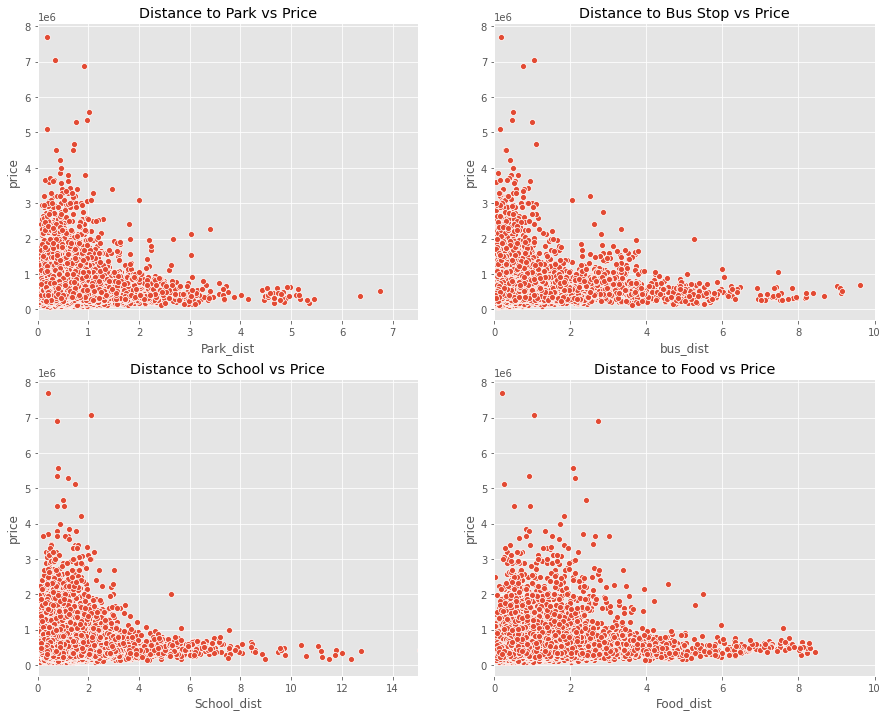

In [56]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 12))

ax1 = sns.scatterplot(x='Park_dist', y = 'price', data=df_price_clean, ax=ax1)
ax1.set_xlim(0,7.5)
ax1.set_title('Distance to Park vs Price')

ax2 = sns.scatterplot(x='bus_dist', y = 'price', data=df_price_clean, ax=ax2)
ax2.set_xlim(0,10)
ax2.set_title('Distance to Bus Stop vs Price')
      
ax3 = sns.scatterplot(x='School_dist', y = 'price', data=df_price_clean, ax=ax3)
ax3.set_xlim(0,15)
ax3.set_title('Distance to School vs Price')

ax4 = sns.scatterplot(x='Food_dist', y = 'price', data=df_price_clean, ax=ax4)
ax4.set_xlim(0,10)
ax4.set_title('Distance to Food vs Price')



### Interpretation: 
The smaller the distance is, the bigger range the price would be. 

Text(0.5, 1.0, 'Distance to Food vs Price')

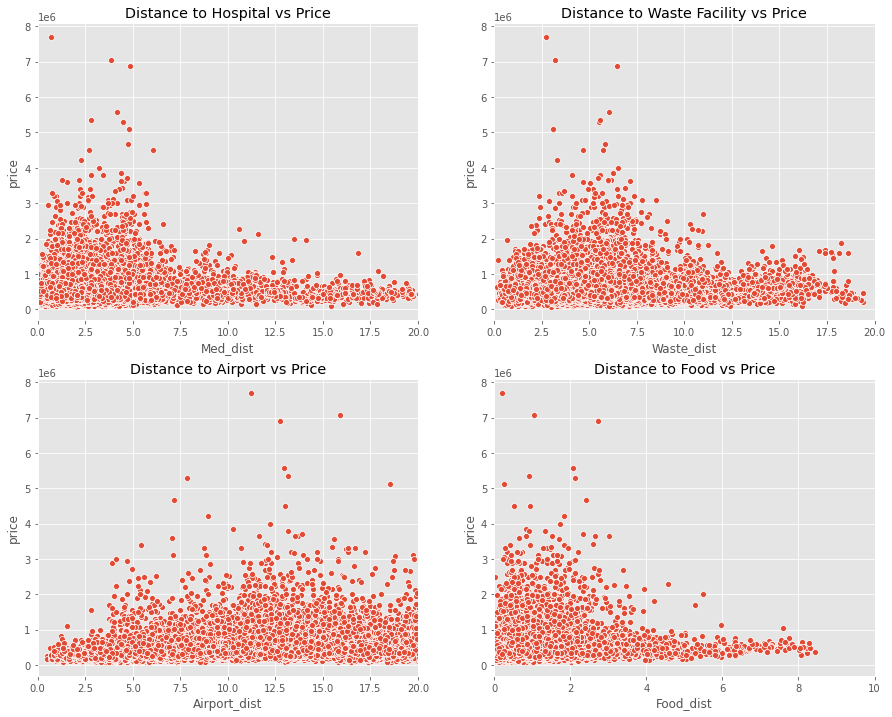

In [57]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 12))

ax1 = sns.scatterplot(x='Med_dist', y = 'price', data=df_price_clean, ax=ax1)
ax1.set_xlim(0,20)
ax1.set_title('Distance to Hospital vs Price')

ax2 = sns.scatterplot(x='Waste_dist', y = 'price', data=df_price_clean, ax=ax2)
ax2.set_xlim(0,20)
ax2.set_title('Distance to Waste Facility vs Price')
      
ax3 = sns.scatterplot(x='Airport_dist', y = 'price', data=df_price_clean, ax=ax3)
ax3.set_xlim(0,20)
ax3.set_title('Distance to Airport vs Price')

ax4 = sns.scatterplot(x='Food_dist', y = 'price', data=df_price_clean, ax=ax4)
ax4.set_xlim(0,10)
ax4.set_title('Distance to Food vs Price')

### Interpretations:
**Hospital** seems to be a preferred feature here.
<br/>
**Airport** is not a preferred feature.
<br/>
**Solid Waste Facility** shows within a moderate distance is acceptable

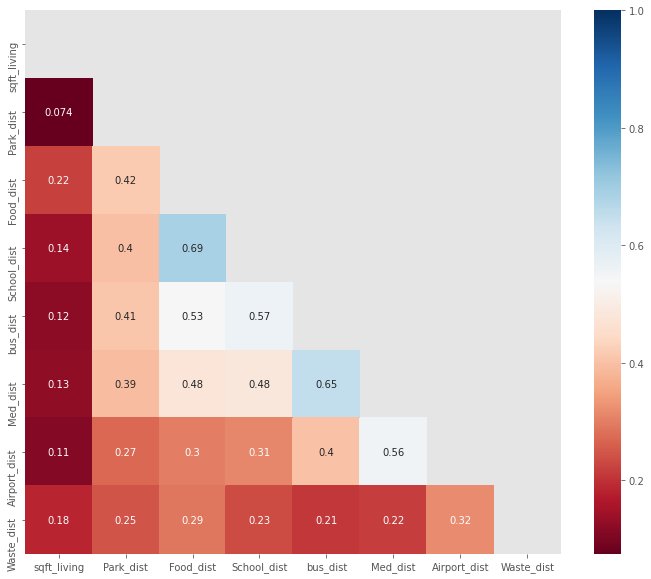

In [58]:
# Let's look at if there are colinearity`
plt.figure(figsize=(12,10))
df_clean_corr = df_price_clean[['sqft_living', 'Park_dist', 'Food_dist', 'School_dist',
                                'bus_dist', 'Med_dist', 
        'Airport_dist', 'Waste_dist']]
corrs = df_clean_corr.corr()
mask = np.triu(np.ones_like(corrs, dtype=np.bool))
sns.heatmap(corrs, mask=mask,
        xticklabels=corrs.columns,
        yticklabels=corrs.columns, cmap='RdBu', annot=True)

## Interpretations: school and food have the strongest correlation

In [59]:
df_price_clean.columns

Index(['id', 'price', 'sqft_living', 'zipcode', 'lat', 'long', 'geometry',
       'Nearest_Park', 'Nearest_food', 'Nearest_airport', 'Nearest_waste',
       'Nearest_school', 'Nearest_bus', 'Nearest_med', 'Park_dist',
       'Food_dist', 'Med_dist', 'Airport_dist', 'Waste_dist', 'School_dist',
       'bus_dist'],
      dtype='object')

In [60]:
# Stats Model looking for correlation
model1 = smf.ols(formula='price ~ Park_dist + School_dist + Food_dist + bus_dist + Med_dist + Airport_dist + Waste_dist + sqft_living', 
                 data=df_price_clean).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     2876.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:32:19   Log-Likelihood:            -2.9956e+05
No. Observations:               21597   AIC:                         5.991e+05
Df Residuals:                   21588   BIC:                         5.992e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3.425e+04   5646.649      6.065      0.000    2.32e+04    4.53e+04
Park_dist    -7.094e+04   4405.612    -16.102      0.000   -7.96e+04   -6.23e+04
School_dist   8930.3458   2822.646      3.164      0.002    3397.750    1.45e+04
Food_dist    -2.403e+04   2897.005     -8.294      0.000   -2.97e+04   -1.84e+04
bus_dist     -3681.3579   2249.403     -1.637      0.102   -8090.355     727.639
Med_dist     -1629.7042    800.010     -2.037      0.042   -3197.783     -61.625
Airport_dist   297.2225    228.990      1.298      0.194    -151.615     746.060
Waste_dist   -7348.9168    586.604    -12.528      0.000   -8498.703   -6199.131
sqft_living    293.1444      1.963    149.369      0.000     289.298     296.991
==============================================================================
Omnibus:                    14717.849   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           550867.176
Skew:                           2.788   Prob(JB):                         0.00
Kurtosis:                      27.105   Cond. No.                     7.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interpretation: 
1. Distance to bus stops and airports seem to be not very signicant. It can be possible that many people do drive in Kings County.
2. From previous graph, we noticed that price tend to be similar (smaller range) after certain distnace. The next step would be excluding some outliers and see if the model can have better predictability power

## Model testing

In [61]:
# Model testing
X = df_price_clean[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
                    'Waste_dist', 'sqft_living']]
y = df_price_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
model.score(X_test, y_test)

0.5126689354958573

In [62]:
# Cross-validation
kfold = model_selection.KFold(n_splits=10, random_state=123)
model_kfold = LinearRegression()
results_kfold = model_selection.cross_val_score(model_kfold, X, y, cv=kfold)
print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

Accuracy: 51.24%


## Polynomial

In [63]:
X = df_price_clean[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
                    'Waste_dist', 'sqft_living']]
y = df_price_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)

In [64]:
for index, degree in enumerate([2, 3, 4, 5]):
    
    # Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree)
    
    # Fit and transform X_train
    X_poly_train = poly.fit_transform(X_train)
    
    # Instantiate and fit a linear regression model to the polynomial transformed train features
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    # Transform the test data into polynomial features
    X_poly_test = poly.transform(X_test)
    
    # Get predicted values for transformed polynomial test data  
    y_pred = reg_poly.predict(X_poly_test)
    
    # Evaluate model performance on test data
    print("degree %d" % degree, r2_score(y_test, y_pred))
    
    # Transform the full data
    X_poly = poly.transform(X)
    
    # Now, we want to see what the model predicts for the entire data  
    y_poly = reg_poly.predict(X_poly)


degree 2 0.5761885492071793
degree 3 0.6086884231904198
degree 4 -2.534411123081385
degree 5 0.2238999763801668


### Next Step: 
The predicting power is the highest for 3rd degree polynomial. As we noticed before from distances, let's try to exclude the outliers and see if that would improve the model

In [66]:
# Using 6km as a threshold for food, bus stop, and schools
# 15 km for hospitals
# 4km for parks
# Further from the airport (at least 2km)
# Further from the waste facility (at least 2km)
df_price_clean_small = df_price_clean[(df_price_clean.Food_dist<6)&(df_price_clean.School_dist<6)&(df_price_clean.bus_dist<6)&(df_price_clean.Park_dist<4)&(df_price_clean.Airport_dist>2)&(df_price_clean.Waste_dist>2)&(df_price_clean.Med_dist<15)]
len(df_price_clean_small)

19108

In [67]:
# Check OLS model
model2 = smf.ols(formula='price ~ Park_dist + School_dist + Food_dist + bus_dist + Med_dist + Airport_dist + Waste_dist + sqft_living', 
                 data=df_price_clean_small).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     2701.
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:33:13   Log-Likelihood:            -2.6536e+05
No. Observations:               19108   AIC:                         5.307e+05
Df Residuals:                   19099   BIC:                         5.308e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.151e+04   6548.390      6.339      0.000    2.87e+04    5.43e+04
Park_dist    -8.173e+04   5168.845    -15.812      0.000   -9.19e+04   -7.16e+04
School_dist   1.382e+04   3894.548      3.550      0.000    6191.079    2.15e+04
Food_dist    -2.189e+04   3587.859     -6.100      0.000   -2.89e+04   -1.49e+04
bus_dist     -2.868e+04   3900.987     -7.351      0.000   -3.63e+04    -2.1e+04
Med_dist     -2248.6372   1071.856     -2.098      0.036   -4349.569    -147.705
Airport_dist   141.1046    256.290      0.551      0.582    -361.247     643.456
Waste_dist   -9298.4293    704.444    -13.200      0.000   -1.07e+04   -7917.658
sqft_living    306.0482      2.129    143.755      0.000     301.875     310.221
==============================================================================
Omnibus:                    12666.908   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           434939.528
Skew:                           2.701   Prob(JB):                         0.00
Kurtosis:                      25.740   Cond. No.                     8.61e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.61e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interpretation: 
The R score increased a little bit. P value for all feasures are demonstrating: they are significant features. 

In [68]:
# Model testing
X = df_price_clean_small[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
                    'Waste_dist', 'sqft_living']]
y = df_price_clean_small['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
model.score(X_test, y_test)

0.5231260947999261

In [69]:
X = df_price_clean_small[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
                    'Waste_dist', 'sqft_living']]
y = df_price_clean_small['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
for index, degree in enumerate([2, 3, 4, 5]):
    
    # Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree)
    
    # Fit and transform X_train
    X_poly_train = poly.fit_transform(X_train)
    
    # Instantiate and fit a linear regression model to the polynomial transformed train features
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    # Transform the test data into polynomial features
    X_poly_test = poly.transform(X_test)
    
    # Get predicted values for transformed polynomial test data  
    y_pred = reg_poly.predict(X_poly_test)
    
    # Evaluate model performance on test data
    print("degree %d" % degree, r2_score(y_test, y_pred))
    
    # Transform the full data
    X_poly = poly.transform(X)
    
    # Now, we want to see what the model predicts for the entire data  
    y_poly = reg_poly.predict(X_poly)

degree 2 0.6099006113376184
degree 3 0.6328896569821227
degree 4 0.6390709374096457
degree 5 0.6665352085064495


### Interpretation: 
Polynomial increase around 2 percent. Interesting the degree 4 shows a positive score this time. 

## Spatial regions correction
For a neighbourhood (by Zipcode) that is bigger, price statistics can be biased. The size of a certain neighbourhood can affect the house density, distance to important features and furthermore, the price. 
Based on the size of the neighbourhood, let's do a spatial lag correction on the price and see if that would help with improving the model. 

In [70]:
# Zipcode boundary
zip_link = 'https://opendata.arcgis.com/datasets/e6c555c6ae7542b2bdec92485892b6e6_113.zip'
urllib.request.urlretrieve(zip_link, 'zip_file.gz')
!mkdir zipcode
!unzip -d zipcode zip_file.gz
zip_poly = gpd.GeoDataFrame.from_file(glob.glob("zipcode/*.shp")[0])

mkdir: zipcode: File exists
Archive:  zip_file.gz
replace zipcode/Zipcodes_for_King_County_and_Surrounding_Area___zipcode_area.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [111]:
df_price_clean.zipcode = df_price_clean.zipcode.astype(int)
zip_poly.ZIPCODE = zip_poly.ZIPCODE.astype(int)
df_zip_join = pd.merge(df_price_clean, zip_poly, left_on = 'zipcode', 
                       right_on = 'ZIPCODE', how='left' )
df_join_sl = df_zip_join
zip_list = [i for i in df_zip_join.ZIPCODE.unique()]
zip_houses = zip_poly[zip_poly.ZIPCODE.isin(zip_list)]

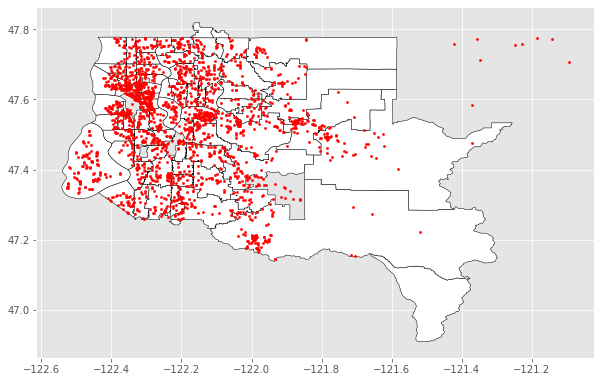

In [99]:
ax = plt.figure(figsize=(10, 10)).add_subplot(111)
set1 = zip_houses.plot(edgecolor='Black', color = 'white', ax=ax, legend=True)
set2 = parks.plot(color='Red', ax=ax, markersize=5)

### Interpretation:
A few houses in the further east area did not show a proper zipcode base. Those houses will be excluded. 

## Spatial Lag

In [147]:
df_spatial = df[['id', 'price', 'sqft_living', 'lat', 'long', 'zipcode']]
df_spatial['price_per_sqft'] = df_spatial.price/df_spatial.sqft_living
df_spatial_geo = gpd.GeoDataFrame(df_spatial, 
                              geometry=gpd.points_from_xy(df_spatial.long, df_spatial.lat))
df_spatial.zipcode = df_spatial.zipcode.astype(int)
zip_poly.ZIPCODE = zip_poly.ZIPCODE.astype(int)

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lavendershenghaozhang/.local/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [174]:
group_price_med = df_spatial.groupby(['zipcode'])['price'].agg('median')
group_price_mu = df_spatial.groupby(['zipcode'])['price'].agg('mean')
group_med = pd.DataFrame(group_price_med)
group_mu = pd.DataFrame(group_price_mu)

In [175]:
group_new_med = pd.merge(group_med, zip_poly, left_on = 'zipcode', 
                         right_on='ZIPCODE', how='left')
group_new_mu = pd.merge(group_mu, zip_poly, left_on = 'zipcode', 
                         right_on='ZIPCODE', how='left')
group_geo_med = gpd.GeoDataFrame(group_new_med, geometry = 'geometry')
group_geo_mu = gpd.GeoDataFrame(group_new_mu, geometry = 'geometry')

In [178]:
# Autocorrection median
# Price correction 
df_sl_med = group_geo_med
wq =lps.weights.Queen.from_dataframe(df_sl_med)
wq.transform = 'r'
y = df_sl_med['price']
ylag = lps.weights.lag_spatial(wq, y)
ylagq5 = mc.Quantiles(ylag, k=6)

# Autocorrection mean
# Price correction 
df_sl_mu = group_geo_mu
wq_mu = lps.weights.Queen.from_dataframe(df_sl_mu)
wq_mu.transform = 'r'
y_mu = df_sl_mu['price']
ylag_mu = lps.weights.lag_spatial(wq, y_mu)
ylagq5_mu = mc.Quantiles(ylag, k=6)

Text(0.5, 1.0, 'Spatial Lag Price')

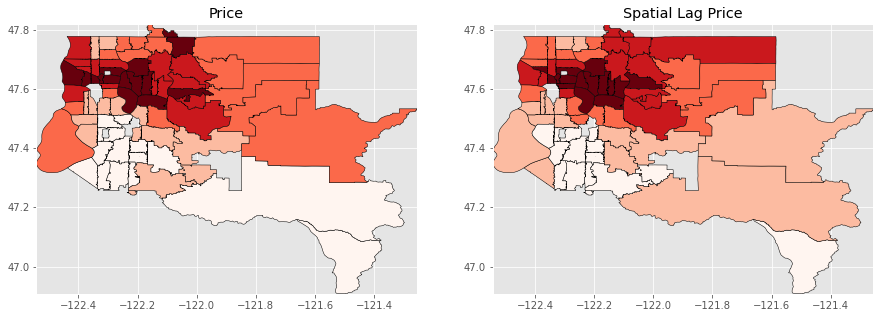

In [177]:
df_sl_med['lag_median_pri'] = ylag
fig,(ax1, ax2) = plt.subplots(1,2,figsize=(15,8))
#price vs lag corrected price
df_sl_med.plot(column='price', ax=ax1, edgecolor='k',
        scheme="quantiles",  k=5, cmap='Reds')
ax1.axis(df_sl.total_bounds[np.asarray([0,2,1,3])])
ax1.set_title("Price")
df_sl_med.plot(column='lag_median_pri', ax=ax2, edgecolor='k',
        scheme='quantiles', cmap='Reds', k=5)
ax2.axis(df_sl.total_bounds[np.asarray([0,2,1,3])])
ax2.set_title("Spatial Lag Price")

### Transforming the price data based on the new Zipcode median
Local transformation for each houses price

In [159]:
df_sl_med['factor'] = df_sl_med['lag_median_pri']/df_sl_med['price']

In [160]:
df_factors_med = df_sl_med[['ZIPCODE', 'factor']]
df_price_clean_small.zipcode = df_price_clean_small.zipcode.astype(int)
df_med = pd.merge(df_price_clean_small, df_factors_med, 
                   left_on='zipcode', right_on='ZIPCODE', how='left')
df_med['price_adj'] = df_med.price * df_med.factor

In [168]:
# Run model again
X = df_med[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
                    'Waste_dist', 'sqft_living']]
y = df_med['price_adj']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
model.score(X_test, y_test)

0.48173113700204906

In [170]:
X = df_med[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
                    'Waste_dist', 'sqft_living']]
y = df_med['price_adj']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
for index, degree in enumerate([2, 3, 4, 5]):
    
    # Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree)
    
    # Fit and transform X_train
    X_poly_train = poly.fit_transform(X_train)
    
    # Instantiate and fit a linear regression model to the polynomial transformed train features
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    # Transform the test data into polynomial features
    X_poly_test = poly.transform(X_test)
    
    # Get predicted values for transformed polynomial test data  
    y_pred = reg_poly.predict(X_poly_test)
    
    # Evaluate model performance on test data
    print("degree %d" % degree, r2_score(y_test, y_pred))
    
    # Transform the full data
    X_poly = poly.transform(X)
    
    # Now, we want to see what the model predicts for the entire data  
    y_poly = reg_poly.predict(X_poly)

degree 2 0.534750172626887
degree 3 0.5642555677970542
degree 4 0.4079632212518276
degree 5 0.37809060559770524


### Transforming the price data based on the new Zipcode mean
Local transformation for each houses price

In [180]:
df_sl_mu['lag_mu_pri'] = ylag_mu
df_sl_mu['factor'] = df_sl_mu['lag_mu_pri']/df_sl_mu['price']

In [181]:
df_factors_mu = df_sl_mu[['ZIPCODE', 'factor']]
df_mu = pd.merge(df_price_clean_small, df_factors_mu, 
                   left_on='zipcode', right_on='ZIPCODE', how='left')
df_mu['price_adj'] = df_mu.price * df_mu.factor

In [182]:
# Run model again
X = df_mu[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
                    'Waste_dist', 'sqft_living']]
y = df_mu['price_adj']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
model.score(X_test, y_test)

0.4861122279858746

In [183]:
X = df_mu[['Park_dist', 'School_dist', 'Food_dist', 'Med_dist', 'Airport_dist',
                    'Waste_dist', 'sqft_living']]
y = df_mu['price_adj']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=52)
for index, degree in enumerate([2, 3, 4, 5]):
    
    # Instantiate PolynomialFeatures
    poly = PolynomialFeatures(degree)
    
    # Fit and transform X_train
    X_poly_train = poly.fit_transform(X_train)
    
    # Instantiate and fit a linear regression model to the polynomial transformed train features
    reg_poly = LinearRegression().fit(X_poly_train, y_train)
    
    # Transform the test data into polynomial features
    X_poly_test = poly.transform(X_test)
    
    # Get predicted values for transformed polynomial test data  
    y_pred = reg_poly.predict(X_poly_test)
    
    # Evaluate model performance on test data
    print("degree %d" % degree, r2_score(y_test, y_pred))
    
    # Transform the full data
    X_poly = poly.transform(X)
    
    # Now, we want to see what the model predicts for the entire data  
    y_poly = reg_poly.predict(X_poly)

degree 2 0.5385452197476129
degree 3 0.563950634286005
degree 4 0.45215202261952203
degree 5 -1.0891050822110722
